In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report


In [2]:
casting_data_path = '../data_set/casting_data/casting_data'
casting_data_train_path = os.path.join(casting_data_path, 'train')
casting_data_test_path = os.path.join(casting_data_path, 'test')

### Definišemo transformacije za pripremu podataka


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Promenite veličinu slike na 128x128 piksela
    transforms.ToTensor(),  # Pretvaramo slike u tenzore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizacija
])

In [4]:
# Kreiranje kompletnog trening skupa
full_train_dataset = ImageFolder(root=casting_data_train_path, transform=transform)
# Podela na trening i validacioni skup
num_train = len(full_train_dataset)
num_val = int(0.2 * num_train)  # 20% za validaciju
train_dataset, val_dataset = random_split(full_train_dataset, [num_train - num_val, num_val])
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=ImageFolder(root=casting_data_test_path, transform=transform), batch_size=32, shuffle=False)

### CNN Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()

In [6]:
# Provera dostupnosti CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)

### Definisanje funkcije gureske i optimizatora


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Funkcija za treniranje modela


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Stavljanje modela u mod za treniranje
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Nuliranje gradijenata
            
            outputs = model(inputs)  # Prolazak unapred
            loss = criterion(outputs, labels)  # Računanje gubitka
            loss.backward()  # Prolazak unazad
            optimizer.step()  # Ažuriranje težina
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Faza validacije
        model.eval()  # Stavljanje modela u mod za evaluaciju
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoha {epoch+1}/{num_epochs}, Trening greska: {epoch_loss:.4f}, Validaciona greska: {val_loss:.4f}, '
              f'Trening tačnost: {train_accuracy:.2f}%, Validaciona tačnost: {val_accuracy:.2f}%')
    
    print('Treniranje završeno')
    return train_losses, val_losses, train_accuracies, val_accuracies




In [9]:
# Treniranje modela
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device)

Epoha 1/30, Trening greska: 0.5773, Validaciona greska: 0.4375, Trening tačnost: 68.53%, Validaciona tačnost: 82.58%
Epoha 2/30, Trening greska: 0.3760, Validaciona greska: 0.3889, Trening tačnost: 83.34%, Validaciona tačnost: 83.86%
Epoha 3/30, Trening greska: 0.3451, Validaciona greska: 0.3243, Trening tačnost: 84.00%, Validaciona tačnost: 86.95%
Epoha 4/30, Trening greska: 0.2766, Validaciona greska: 0.2259, Trening tačnost: 87.79%, Validaciona tačnost: 90.95%
Epoha 5/30, Trening greska: 0.2293, Validaciona greska: 0.1893, Trening tačnost: 89.99%, Validaciona tačnost: 93.74%
Epoha 6/30, Trening greska: 0.2001, Validaciona greska: 0.1721, Trening tačnost: 91.71%, Validaciona tačnost: 93.51%
Epoha 7/30, Trening greska: 0.1826, Validaciona greska: 0.2562, Trening tačnost: 92.78%, Validaciona tačnost: 87.78%
Epoha 8/30, Trening greska: 0.1459, Validaciona greska: 0.1306, Trening tačnost: 94.80%, Validaciona tačnost: 96.15%
Epoha 9/30, Trening greska: 0.1128, Validaciona greska: 0.1157, 

### Funkcija za crtanje greske i tačnosti


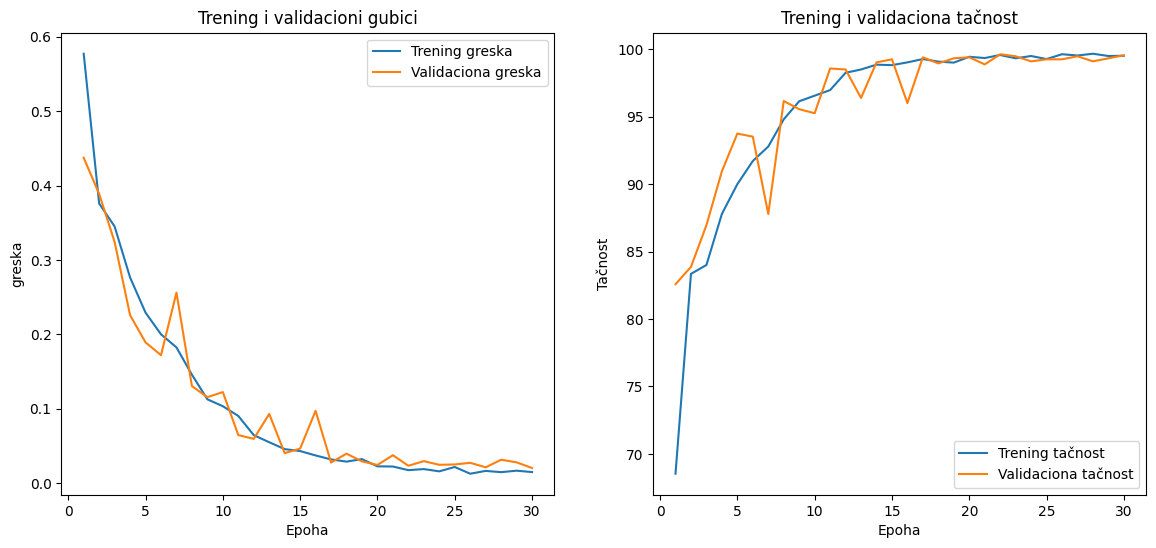

In [10]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Trening greska')
    plt.plot(epochs, val_losses, label='Validaciona greska')
    plt.xlabel('Epoha')
    plt.ylabel('greska')
    plt.title('Trening i validacioni gubici')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Trening tačnost')
    plt.plot(epochs, val_accuracies, label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Trening i validaciona tačnost')
    plt.legend()

    plt.show()



# Crtanje trening i validacione greske i tačnosti
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Evaluacija modela i classification report

In [11]:
def evaluate_model_with_report(model, test_loader, device, class_names):
    model.eval()  # Stavljanje modela u mod za evaluaciju
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Isključivanje proračuna gradijenata
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            # Dodavanje stvarnih labela i predikcija
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Izračunavanje tačnosti i gubitka
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    print(f'Test greska: {test_loss:.4f}, Test tačnost: {test_accuracy:.2f}%')
    
    # Izračunavanje i prikaz classification report-a
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

# Evaluacija modela sa classification reportom
class_names = train_loader.dataset.dataset.classes  # Dobavljanje imena klasa iz trening podataka
evaluate_model_with_report(model, test_loader, device, class_names)


Test greska: 0.0226, Test tačnost: 99.30%

Classification Report:
              precision    recall  f1-score   support

   def_front       1.00      0.99      0.99       453
    ok_front       0.98      1.00      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715

